```{contents}
```

### **Deep (Stacked) RNN — Explanation, Intuition, and Workflow**

---

### 1. **Concept**

A **Deep or Stacked RNN** is a Recurrent Neural Network with **multiple RNN layers stacked on top of each other**, where each layer’s output sequence serves as the input to the next.

It extends the **basic RNN** (which has a single recurrent layer) into a **multi-layer hierarchy** to capture **more complex temporal patterns** and **abstract features** from sequence data.

---

### 2. **Intuition**

Think of a Stacked RNN as a **multi-level temporal feature extractor**:

| Layer             | Role                                                                                        |
| ----------------- | ------------------------------------------------------------------------------------------- |
| **Lower layers**  | Capture short-term, low-level patterns (e.g., local rhythm, phoneme, short word structure). |
| **Higher layers** | Capture long-term, high-level dependencies (e.g., sentence meaning, context, trend).        |

Like CNNs in images — deeper layers detect complex shapes — in RNNs, deeper layers detect complex time relationships.

---

#### Architecture Overview

![alt text](../../images/deepRNN.png)

If a single-layer RNN has:

$$
h_t = f(W_{xh}x_t + W_{hh}h_{t-1} + b_h)
$$

Then a stacked RNN with *L* layers computes:

$$
h_t^{(1)} = f(W_{xh}^{(1)}x_t + W_{hh}^{(1)}h_{t-1}^{(1)} + b^{(1)})
$$

$$
h_t^{(2)} = f(W_{xh}^{(2)}h_t^{(1)} + W_{hh}^{(2)}h_{t-1}^{(2)} + b^{(2)})
$$

$$
\vdots
$$

$$
h_t^{(L)} = f(W_{xh}^{(L)}h_t^{(L-1)} + W_{hh}^{(L)}h_{t-1}^{(L)} + b^{(L)})
$$

Only the top layer’s output is typically passed to the next network component (e.g., classifier or dense layer).

---

#### Workflow Summary

| Step | Component               | Operation                              | Purpose                                  |
| ---- | ----------------------- | -------------------------------------- | ---------------------------------------- |
| 1    | Input layer             | Feed sequence ( x_1, x_2, \dots, x_T ) | Sequential data input                    |
| 2    | First RNN layer         | Produces hidden sequence ( h_t^{(1)} ) | Learn local temporal structure           |
| 3    | Second RNN layer        | Takes ( h_t^{(1)} ) as input           | Learn higher-order temporal abstractions |
| 4    | Final RNN / Dense layer | Generates output                       | Predict or classify                      |
| 5    | Loss optimization       | Backpropagation through time (BPTT)    | Adjust all layers jointly                |

---

#### Deep RNN vs Shallow RNN

| Feature                | Shallow RNN              | Deep (Stacked) RNN                            |
| ---------------------- | ------------------------ | --------------------------------------------- |
| Layers                 | 1                        | 2+                                            |
| Feature depth          | Simple temporal features | Hierarchical temporal abstractions            |
| Representational power | Limited                  | Higher                                        |
| Training time          | Faster                   | Slower                                        |
| Tuning difficulty      | Easier                   | Harder (more parameters, vanishing gradients) |
| Use cases              | Simple time-series       | Complex sequential tasks (speech, NLP)        |

---

#### Variants

You can stack any recurrent cell type:

| Type                    | Description                                 |
| ----------------------- | ------------------------------------------- |
| **Stacked Vanilla RNN** | Basic, but suffers vanishing gradients      |
| **Stacked LSTM**        | Common; handles long-term dependencies well |
| **Stacked GRU**         | Simpler and faster than LSTM                |
| **Stacked BiLSTM/GRU**  | Adds bidirectional context per layer        |

---

#### **Advantages**

| Advantage                   | Explanation                                             |
| --------------------------- | ------------------------------------------------------- |
| **Hierarchical learning**   | Deeper layers capture abstract temporal patterns        |
| **Better generalization**   | Multi-level temporal features improve accuracy          |
| **Reusable representation** | Intermediate features can be used for transfer learning |

---

#### **Disadvantages**

| Disadvantage           | Explanation                                                          |
| ---------------------- | -------------------------------------------------------------------- |
| **More parameters**    | Higher computational cost and memory usage                           |
| **Harder to train**    | Vanishing/exploding gradient risk increases with depth               |
| **Slower convergence** | Needs careful tuning and normalization (e.g., layer norm, residuals) |

---

**Practical Notes**

* Typical depth: **2–4 layers** (beyond that offers diminishing returns).
* Use **Dropout** and **Batch Normalization** to stabilize training.
* Combine with **Residual Connections** (skip connections) to improve gradient flow.



---

**Use Cases**

* Speech recognition
* Sentiment analysis
* Time-series forecasting
* Language modeling
* Stock or sensor prediction

---

**Summary Analogy**

| Model          | Analogy                                                        |
| -------------- | -------------------------------------------------------------- |
| **Simple RNN** | A single memory unit reading a sequence                        |
| **LSTM / GRU** | A smart memory unit with gates                                 |
| **BiRNN**      | Two smart units — one looks forward, one backward              |
| **Deep RNN**   | A hierarchy of memory units — each level refines understanding |


### Demonstration

---

#### **Cell 1 — Install and Import Libraries**



In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
import itertools
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


---

#### **Cell 2 — Generate Synthetic Time Series Data**

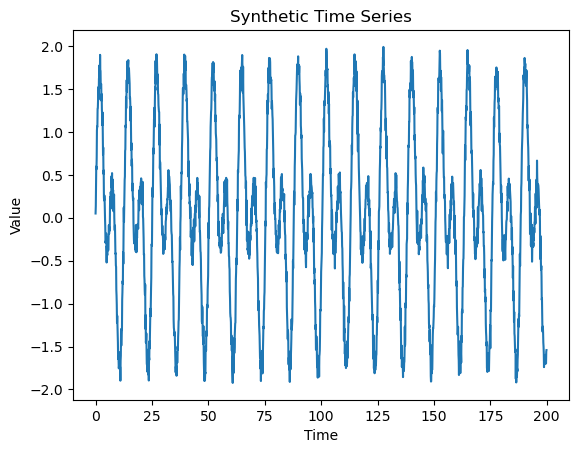

In [8]:

np.random.seed(42)
time = np.arange(0, 200, 0.1)
data = np.sin(time) + np.sin(0.5 * time) + np.random.normal(0, 0.1, len(time))

plt.plot(time, data)
plt.title("Synthetic Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()


---

#### **Cell 3 — Prepare the Dataset**

In [9]:

window_size = 30
X, y = [], []

for i in range(len(data) - window_size):
    X.append(data[i:i + window_size])
    y.append(data[i + window_size])

X = np.array(X).reshape(-1, window_size, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")


Train samples: 1576, Test samples: 394



---

#### **Cell 4 — Define Hyperparameter Grid and Callbacks**



In [10]:

# Define hyperparameters to tune
units_list = [32, 64]
dropouts = [0.1, 0.3]
learning_rates = [0.001, 0.005]
batch_sizes = [16, 32]

# Learning rate scheduler: gradual decay
def lr_scheduler(epoch, lr):
    return lr * 0.9 if epoch > 10 else lr

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


---

#### **Cell 5 — Train and Evaluate Deep LSTM Models**



In [11]:

results = []

for units, dropout, lr, batch in itertools.product(units_list, dropouts, learning_rates, batch_sizes):
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=(window_size, 1)),
        Dropout(dropout),
        LSTM(units, return_sequences=True),
        Dropout(dropout),
        LSTM(units),
        Dense(1)
    ])
    
    optimizer = Adam(learning_rate=lr)
    model.compile(loss='mse', optimizer=optimizer)

    history = model.fit(
        X_train, y_train,
        epochs=5,
        batch_size=batch,
        validation_split=0.1,
        verbose=0,
        callbacks=[early_stop, LearningRateScheduler(lr_scheduler)]
    )

    test_loss = model.evaluate(X_test, y_test, verbose=0)
    results.append((units, dropout, lr, batch, test_loss))

results_df = pd.DataFrame(results, columns=["Units", "Dropout", "Learning Rate", "Batch Size", "Test Loss"])
results_df


,Units,Dropout,Learning Rate,Batch Size,Test Loss
0,32,0.1,0.001,16,0.013114
1,32,0.1,0.001,32,0.012691
2,32,0.1,0.005,16,0.013718
3,32,0.1,0.005,32,0.013264
4,32,0.3,0.001,16,0.014598
5,32,0.3,0.001,32,0.013379
6,32,0.3,0.005,16,0.014845
7,32,0.3,0.005,32,0.013923
8,64,0.1,0.001,16,0.013016
9,64,0.1,0.001,32,0.013961


---

#### **Cell 6 — Select Best Configuration**

In [12]:

best_config = results_df.loc[results_df["Test Loss"].idxmin()]
print("Best Configuration:")
print(best_config)


Best Configuration:
Units            32.000000
Dropout           0.100000
Learning Rate     0.001000
Batch Size       32.000000
Test Loss         0.012691
Name: 1, dtype: float64




---

#### **Cell 7 — Retrain Best Deep LSTM and Visualize Predictions**



Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 0.6877 - val_loss: 0.0795 - learning_rate: 0.0010
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0780 - val_loss: 0.0468 - learning_rate: 0.0010
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0436 - val_loss: 0.0265 - learning_rate: 0.0010
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0279 - val_loss: 0.0153 - learning_rate: 0.0010
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0179 - val_loss: 0.0157 - learning_rate: 0.0010
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0164 - val_loss: 0.0171 - learning_rate: 0.0010
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0152 - val_loss: 0.0168 - learning_rate: 0.0010
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0155 - val_loss: 0.0159 - learning_rate: 0.0010
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0153 - val_loss: 0.0170 - learning_rate: 0.0010
13/13 ━━━━━━━━━━━━━

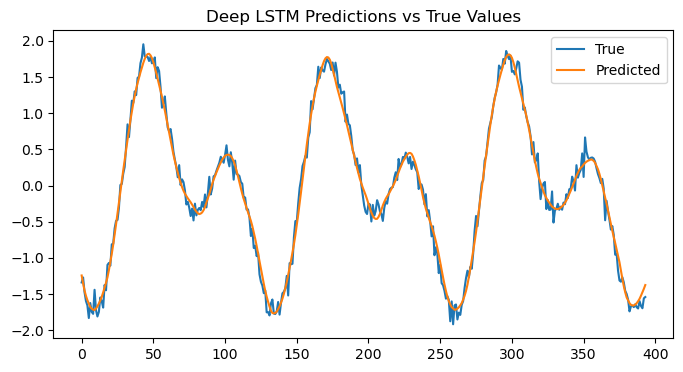

In [13]:

best_units = int(best_config["Units"])
best_dropout = float(best_config["Dropout"])
best_lr = float(best_config["Learning Rate"])
best_batch = int(best_config["Batch Size"])

best_model = Sequential([
    LSTM(best_units, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(best_dropout),
    LSTM(best_units, return_sequences=True),
    Dropout(best_dropout),
    LSTM(best_units),
    Dense(1)
])

best_model.compile(loss='mse', optimizer=Adam(learning_rate=best_lr))

history = best_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=best_batch,
    validation_split=0.1,
    verbose=1,
    callbacks=[early_stop, LearningRateScheduler(lr_scheduler)]
)

preds = best_model.predict(X_test)

plt.figure(figsize=(8,4))
plt.plot(y_test, label="True")
plt.plot(preds, label="Predicted")
plt.title("Deep LSTM Predictions vs True Values")
plt.legend()
plt.show()


---

### **Explanation of the Workflow**

| Step | Operation                                    | Purpose                                                   |
| ---- | -------------------------------------------- | --------------------------------------------------------- |
| 1    | Generate synthetic data                      | Simulates complex temporal behavior                       |
| 2    | Convert to sliding windows                   | Creates sequence samples                                  |
| 3    | Define deep LSTM                             | Multi-layer recurrent structure for hierarchical learning |
| 4    | Tune hyperparameters                         | Grid search to optimize model performance                 |
| 5    | Apply early stopping and learning rate decay | Prevent overfitting and improve convergence               |
| 6    | Retrain best configuration                   | Obtain optimal final model                                |
| 7    | Evaluate and visualize                       | Assess forecasting accuracy                               |

---

### **Hyperparameter Tuning Strategy**

| Hyperparameter       | Role                                   | Typical Range |
| -------------------- | -------------------------------------- | ------------- |
| **Units**            | Controls memory capacity               | 32–128        |
| **Dropout**          | Prevents overfitting                   | 0.1–0.5       |
| **Learning Rate**    | Controls update step                   | 0.001–0.01    |
| **Batch Size**       | Affects stability and speed            | 16–64         |
| **Number of Layers** | Controls depth of temporal abstraction | 2–4 layers    |

---

### **Deep vs Shallow RNNs**

| Aspect               | Shallow RNN   | Deep (Stacked) RNN        |
| -------------------- | ------------- | ------------------------- |
| Layers               | 1             | ≥ 2                       |
| Temporal abstraction | Single-level  | Multi-level               |
| Expressiveness       | Limited       | High                      |
| Training difficulty  | Easier        | Harder                    |
| Use cases            | Simple trends | Complex temporal patterns |

---

### **When to Use Deep (Stacked) RNNs**

| Scenario                                | Reason                                             |
| --------------------------------------- | -------------------------------------------------- |
| Long or multi-scale sequences           | Each layer captures different temporal granularity |
| Complex signals (speech, stock, sensor) | Deep architecture models multi-level dynamics      |
| When accuracy > speed                   | Deeper models generalize better                    |
| When sufficient data available          | More parameters need more training data            |

---

Would you like me to **extend this to compare shallow vs deep RNN performance** on the same dataset (side-by-side training curves and accuracy metrics)?
